# Making posterior predictions on new groups in a hierarchcial model

In [1]:
from typing import Optional

import arviz as az
import janitor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnine as gg
import pymc3 as pm
import seaborn as sns

_ = gg.theme_set(
    gg.theme_classic()
    + gg.theme(axis_ticks=gg.element_blank(), strip_background=gg.element_blank())
)
plt.style.use("seaborn-darkgrid")
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
iris = sns.load_dataset("iris")
assert isinstance(iris, pd.DataFrame)
iris["species"] = pd.Categorical(iris.species, ordered=True)
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [3]:
iris.shape

(150, 5)

<AxesSubplot:xlabel='sepal_length', ylabel='sepal_width'>

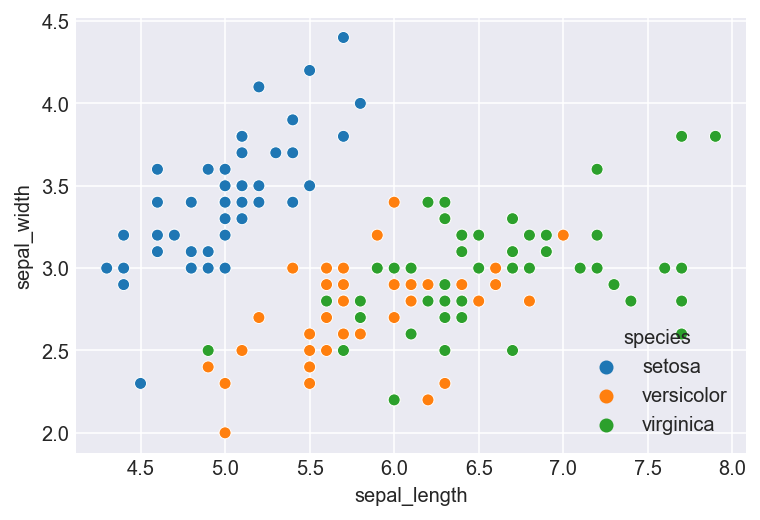

In [4]:
sns.scatterplot(data=iris, x="sepal_length", y="sepal_width", hue="species")

In [5]:
def scale(
    x: np.ndarray, m: Optional[float] = None, s: Optional[float] = None
) -> np.ndarray:
    if m is None:
        m = np.mean(x)
    if s is None:
        s = np.std(x)

    return (x - m) / s

In [6]:
iris["sepal_length_z"] = scale(iris.sepal_length.values)

In [7]:
def get_index(df: pd.DataFrame, col: str) -> np.ndarray:
    return df[col].cat.codes.values

In [8]:
def iris_model_factory(
    sepal_len: np.ndarray,
    sepal_width: np.ndarray,
    species_idx: np.ndarray,
    n_species: int,
) -> pm.Model:
    s = species_idx
    with pm.Model() as m:
        mu_b = pm.Normal("mu_b", 1, 2)
        sigma_b = pm.Gamma("sigma_b", 3, 1)
        b = pm.Normal("b", mu_b, sigma_b, shape=(n_species))

        mu_a = pm.Normal("mu_a", 0, 2)
        sigma_a = pm.HalfNormal("sigma_a", 2)
        a = pm.Normal("a", mu_a, sigma_a, shape=(n_species))

        mu = pm.Deterministic("mu", a[s] + b[s] * sepal_len)
        sigma = pm.HalfNormal("sigma", 1)

        y = pm.Normal("sepal_width", mu, sigma, observed=sepal_width)
    return m

In [9]:
with iris_model_factory(
    sepal_len=iris.sepal_length_z.values,
    sepal_width=iris.sepal_width.values,
    species_idx=get_index(iris, "species"),
    n_species=3,
) as m:
    iris_multitrace = pm.sample(
        target_accept=0.95, random_seed=90, return_inferencedata=False
    )
    iris_ppc = pm.sample_posterior_predictive(iris_multitrace)
    iris_trace = az.from_pymc3(trace=iris_multitrace, posterior_predictive=iris_ppc)

assert isinstance(iris_trace, az.InferenceData)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, a, sigma_a, mu_a, b, sigma_b, mu_b]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 27 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


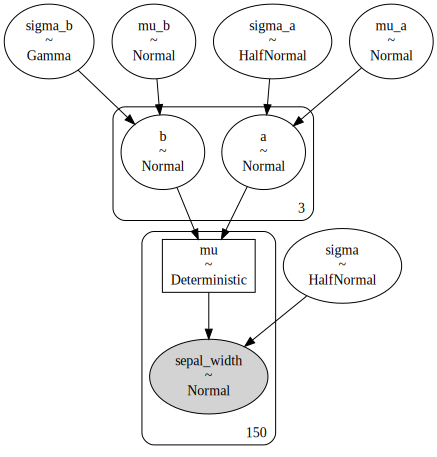

In [10]:
pm.model_to_graphviz(m)

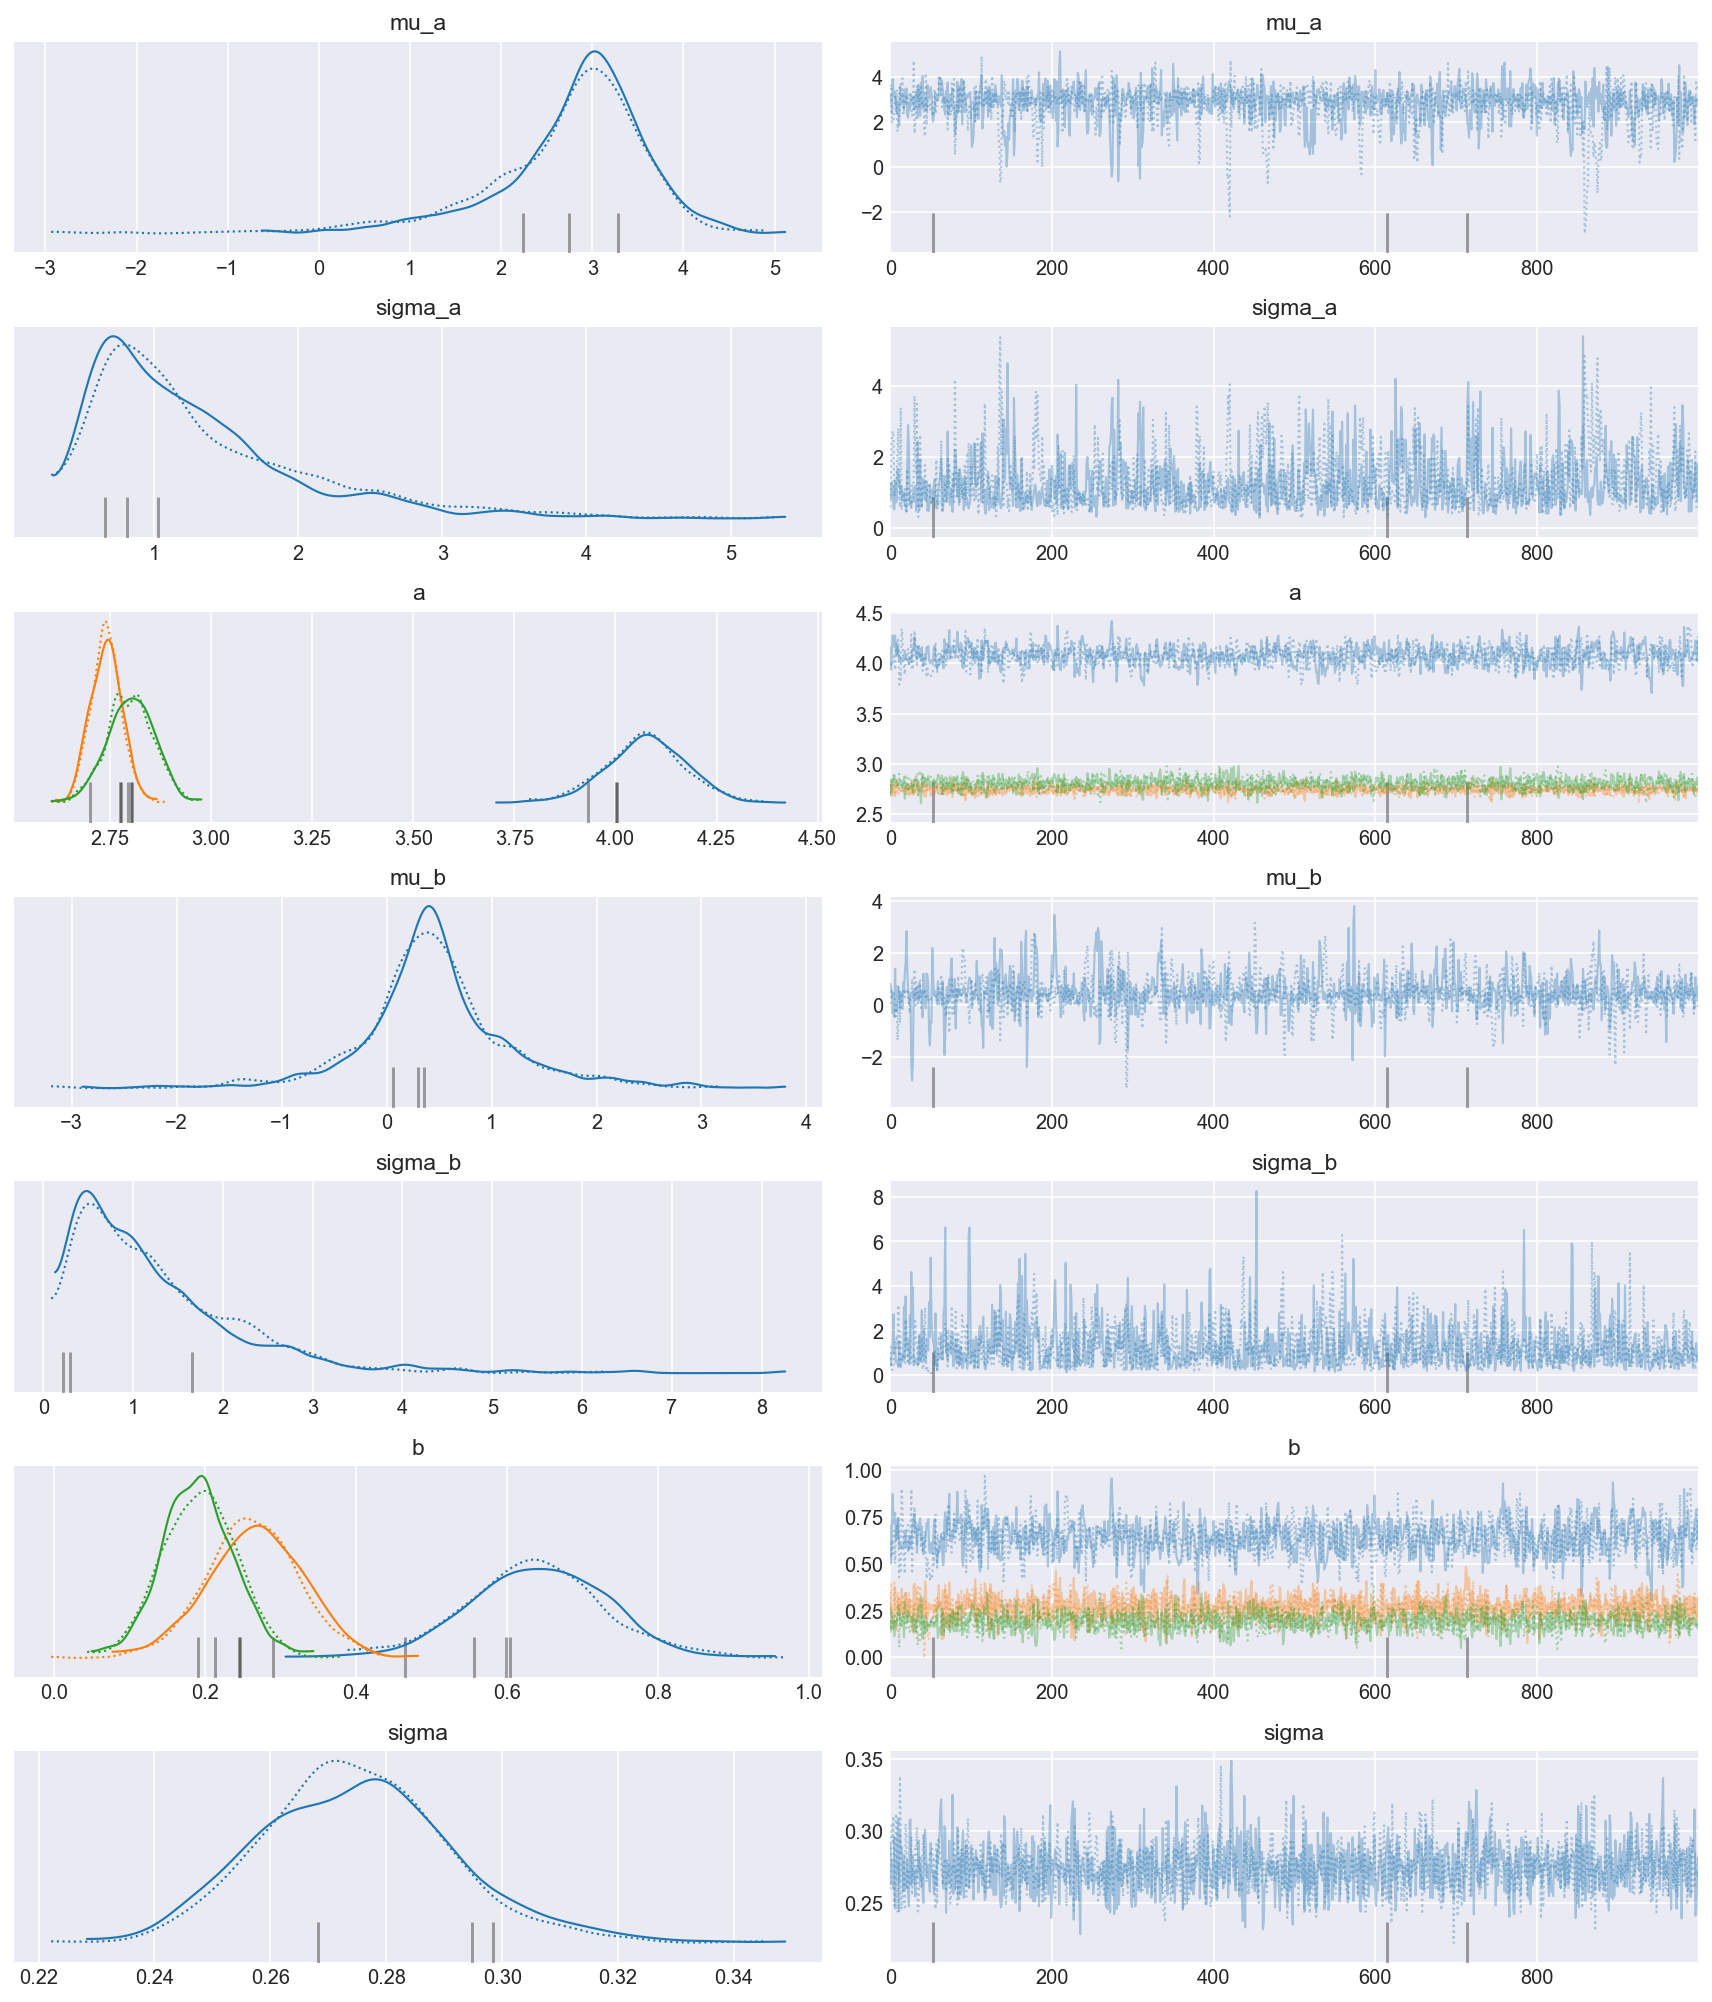

In [11]:
az.plot_trace(
    iris_trace, var_names=["mu_a", "sigma_a", "a", "mu_b", "sigma_b", "b", "sigma"]
)
plt.tight_layout()
plt.show()

<AxesSubplot:xlabel='sepal_width / sepal_width'>

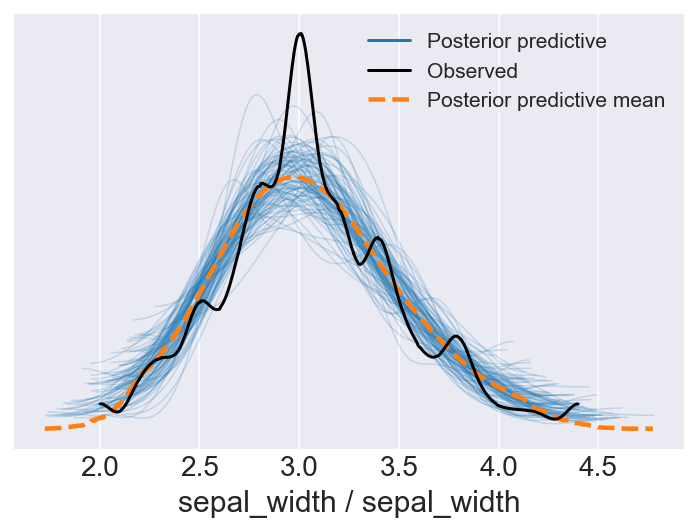

In [12]:
az.plot_ppc(iris_trace, num_pp_samples=100)

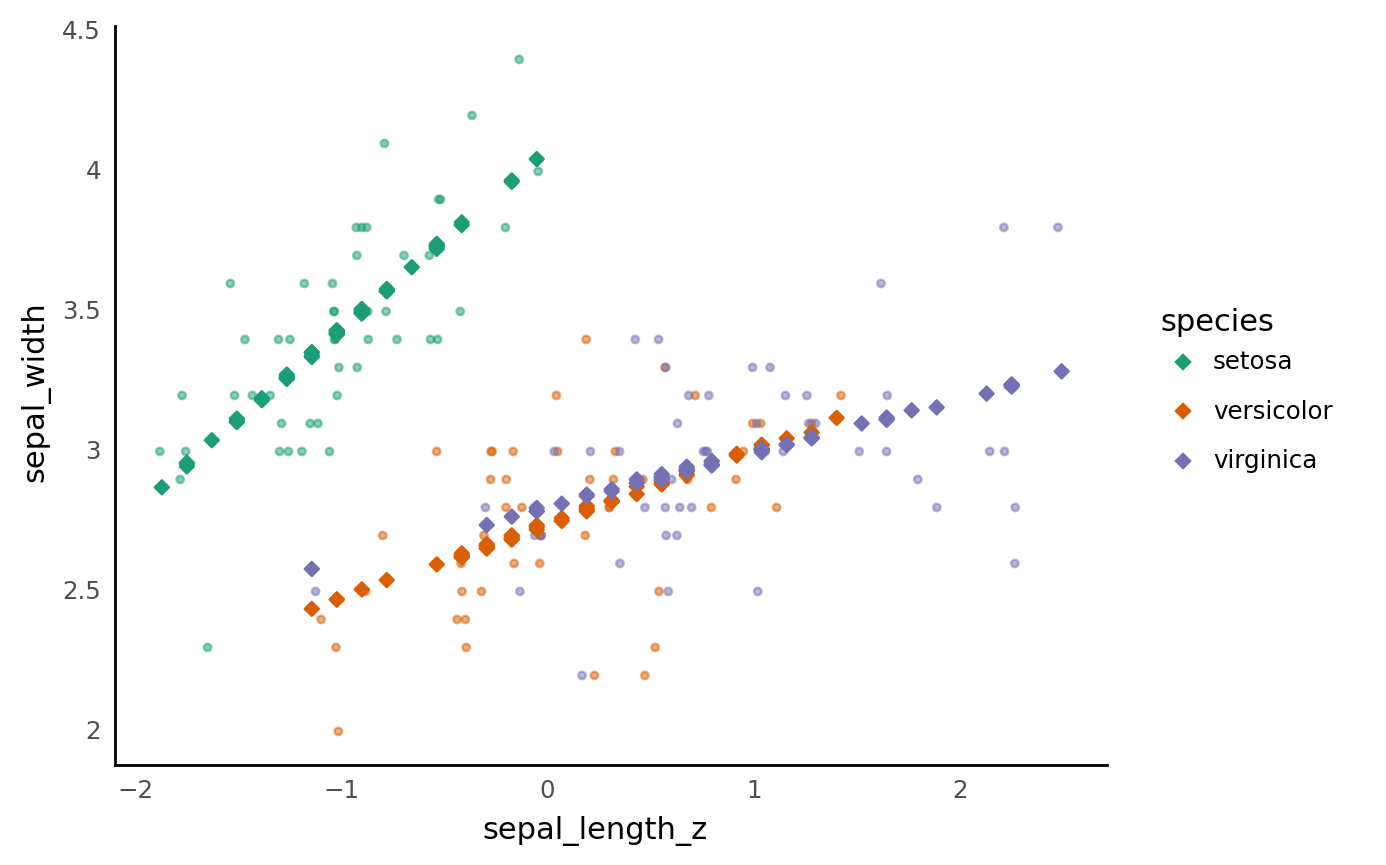

<ggplot: (352017375)>

In [13]:
iris_ppc_mean = (
    iris_trace.posterior_predictive["sepal_width"]
    .values.reshape(-1, len(iris))
    .mean(axis=0)
)

(
    gg.ggplot(iris.assign(ppc_mean=iris_ppc_mean), gg.aes(x="sepal_length_z"))
    + gg.geom_jitter(
        gg.aes(y="sepal_width", color="species"),
        alpha=0.5,
        size=1,
        width=0.05,
        height=0,
    )
    + gg.geom_point(gg.aes(y="ppc_mean", color="species"), shape="D")
    + gg.scale_color_brewer(type="qual", palette="Dark2")
)

In [14]:
n_new_species = 1
_new_sepal_len = np.arange(
    np.min(iris.sepal_length_z) - 0.1, np.max(iris.sepal_length_z) + 0.2, 0.1
)
new_sepal_len = np.tile(_new_sepal_len, n_new_species)
new_species_idx = np.repeat(
    np.arange(n_new_species), len(new_sepal_len) / n_new_species
)
new_sepal_width = np.empty(new_sepal_len.shape[0], dtype=int)

new_iris = pd.DataFrame(
    {
        "sepal_length_z": new_sepal_len,
        "sepal_width": new_sepal_width,
        "species": new_species_idx,
    }
)
new_iris.head()

,sepal_length_z,sepal_width,species
0,-1.970024,5764607523034234880,0
1,-1.870024,5764607523034234880,0
2,-1.770024,4606281698874490908,0
3,-1.670024,607985949695017,0
4,-1.570024,5764607523034234880,0


In [15]:
new_iris.shape

(47, 3)

In [16]:
top_vars = ["mu_a", "sigma_a", "mu_b", "sigma_b", "sigma"]

In [17]:
trace_records = (
    iris_trace.posterior.get(top_vars)
    .to_dataframe()
    .reset_index(drop=True)
    .to_dict("records")
)

trace_records[0]

{'mu_a': 3.1152680422925645,
 'sigma_a': 1.2364984403432382,
 'mu_b': 0.8132218090892008,
 'sigma_b': 0.7701813152174082,
 'sigma': 0.29127900855782063}

In [18]:
trace_records = pm.trace_to_dataframe(
    iris_multitrace, varnames=top_vars, include_transformed=True
).to_dict("records")

trace_records[0]

{'mu_a': 3.1152680422925645,
 'sigma_a': 1.2364984403432382,
 'mu_b': 0.8132218090892008,
 'sigma_b': 0.7701813152174082,
 'sigma': 0.29127900855782063}

In [19]:
with iris_model_factory(
    sepal_len=new_iris.sepal_length_z,
    sepal_width=new_iris.sepal_width,
    species_idx=new_iris.species,
    n_species=n_new_species,
):
    new_iris_ppc = pm.sample_posterior_predictive(
        trace=trace_records,
        samples=len(trace_records),
        var_names=["a", "b", "sepal_width"],
    )

array([<AxesSubplot:title={'center':'mu_a'}>,
       <AxesSubplot:title={'center':'sigma_a'}>], dtype=object)

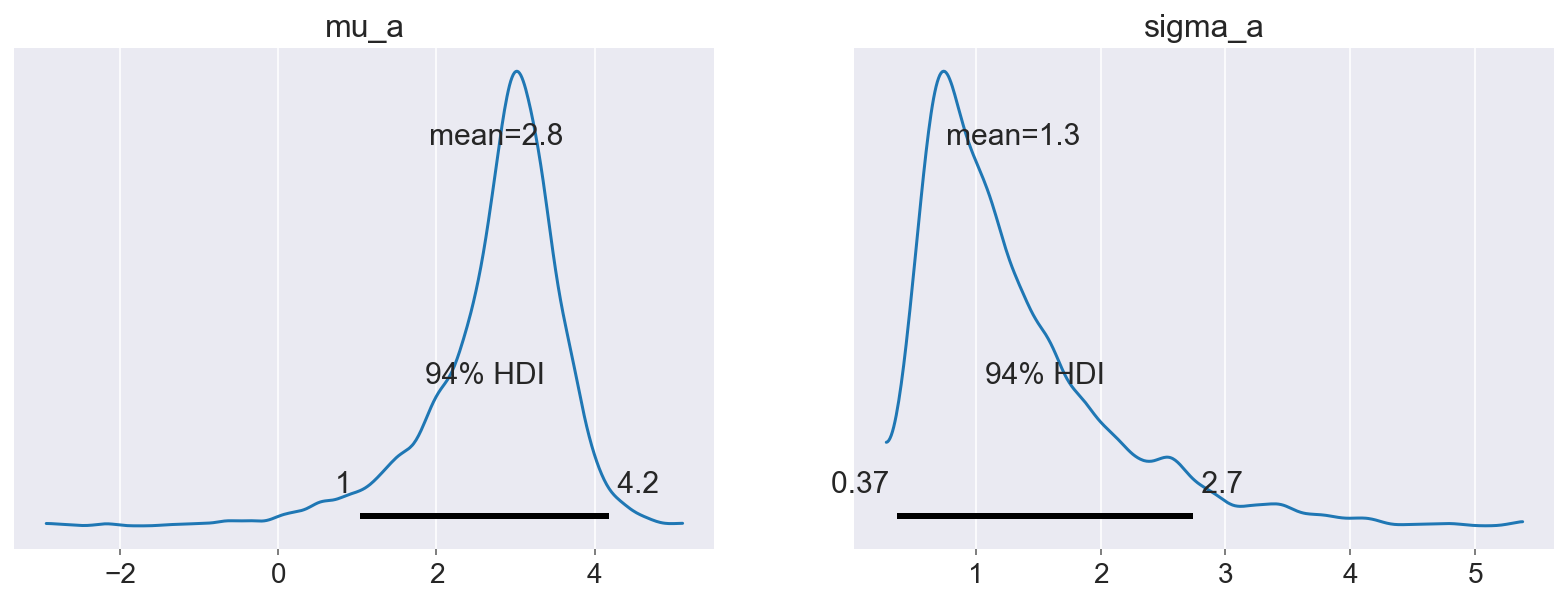

In [20]:
az.plot_posterior(iris_trace, var_names=["mu_a", "sigma_a"])

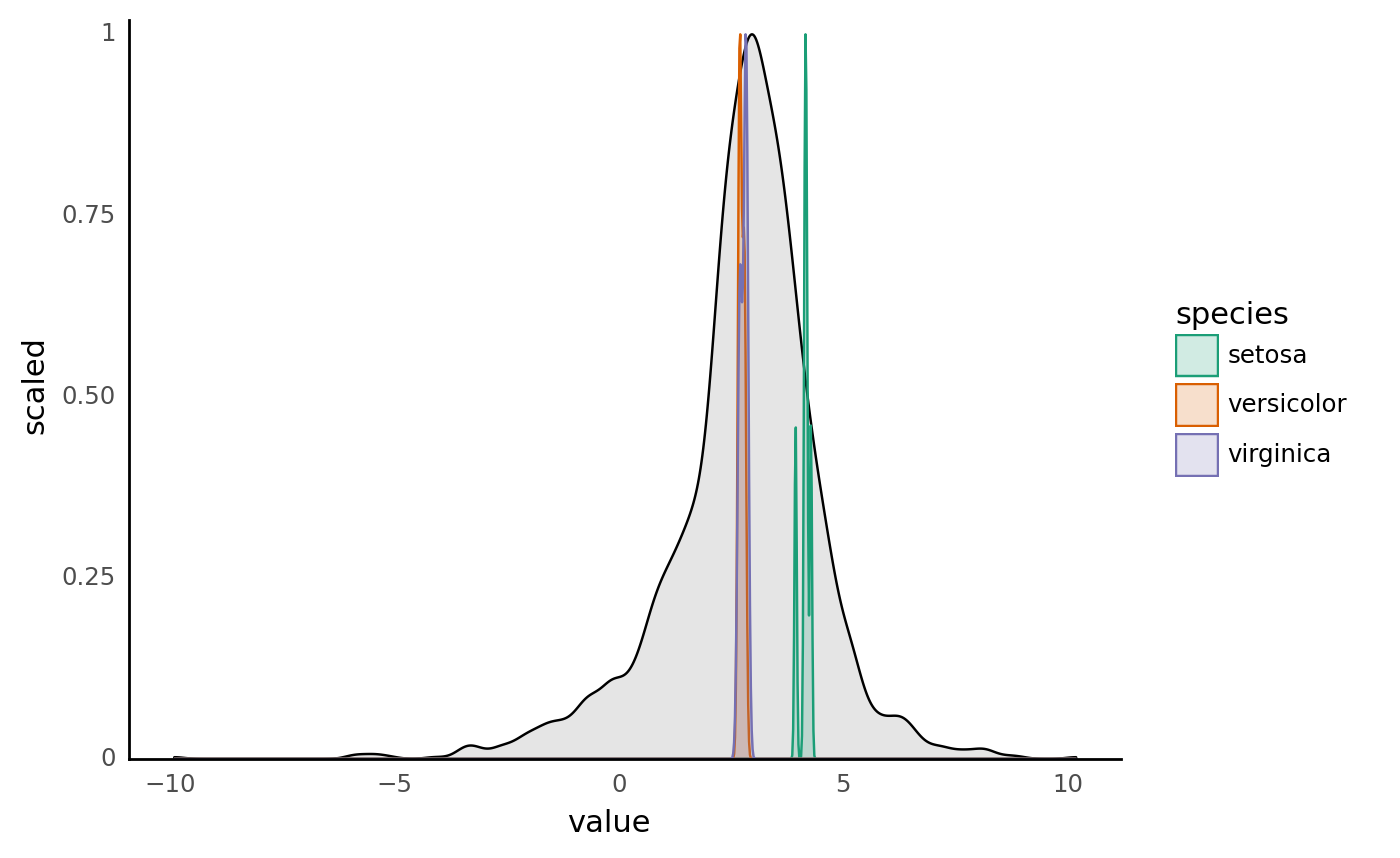

<ggplot: (352581105)>

In [21]:
new_data_posterior_a = pd.DataFrame(
    new_iris_ppc["a"], columns=[f"s{i}" for i in range(n_new_species)]
).pivot_longer(names_to="species")

iris_posterior_a = (
    pd.DataFrame(
        iris_trace.posterior["a"].values.reshape(-1, iris.species.nunique()),
        columns=iris.species.cat.categories,
    )
    .head()
    .pivot_longer(names_to="species")
)

(
    gg.ggplot(new_data_posterior_a, gg.aes(x="value"))
    + gg.geom_density(
        gg.aes(y=gg.after_stat("scaled")), color="black", fill="black", alpha=0.1
    )
    + gg.geom_density(
        gg.aes(color="species", fill="species", y=gg.after_stat("scaled")),
        data=iris_posterior_a,
        alpha=0.2,
    )
    + gg.scale_color_brewer(type="qual", palette="Dark2")
    + gg.scale_fill_brewer(type="qual", palette="Dark2")
    + gg.scale_x_continuous(expand=0)
    + gg.scale_y_continuous(expand=(0, 0, 0.02, 0))
)

In [22]:
for param in ["a", "b"]:
    prop_pos = np.mean(new_iris_ppc[param] > 0).round(2)
    print(f"proportion of '{param}' > 0: {prop_pos}")

proportion of 'a' > 0: 0.93
proportion of 'b' > 0: 0.68


In [23]:
new_ppc_df = (
    pd.DataFrame(new_iris_ppc["sepal_width"])
    .reset_index(drop=False)
    .rename(columns={"index": "draw"})
    .pivot_longer("draw", names_to="data_pt", values_to="value")
    .set_index("data_pt")
    .merge(new_iris, left_index=True, right_index=True)
    .reset_index(drop=False)
    .rename(columns={"index": "data_pt"})
)

new_ppc_df.head()

,data_pt,draw,value,sepal_length_z,sepal_width,species
0,0,0,-2.008921,-1.970024,5764607523034234880,0
1,0,1,2.738855,-1.970024,5764607523034234880,0
2,0,2,2.432017,-1.970024,5764607523034234880,0
3,0,3,3.334118,-1.970024,5764607523034234880,0
4,0,4,-0.886592,-1.970024,5764607523034234880,0


In [24]:
new_ppc_df_avg = (
    new_ppc_df.groupby(["data_pt", "sepal_length_z"])["value"]
    .mean()
    .reset_index(drop=False)
    .merge(
        pd.DataFrame(
            az.hdi(new_iris_ppc["sepal_width"], hdi_prob=0.89),
            columns=["hdi_low", "hdi_high"],
        ),
        left_index=True,
        right_index=True,
    )
)

new_ppc_df_avg.head()

/var/folders/r4/qpcdgl_14hbd412snp1jnv300000gn/T/ipykernel_45817/4113931169.py:7: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions


,data_pt,sepal_length_z,value,hdi_low,hdi_high
0,0,-1.970024,1.872095,-3.758199,7.363495
1,1,-1.870024,1.920238,-3.155270,7.723792
2,2,-1.770024,1.957975,-2.971501,7.447237
3,3,-1.670024,1.988461,-2.740075,7.235244
4,4,-1.570024,2.044742,-2.386891,7.108347


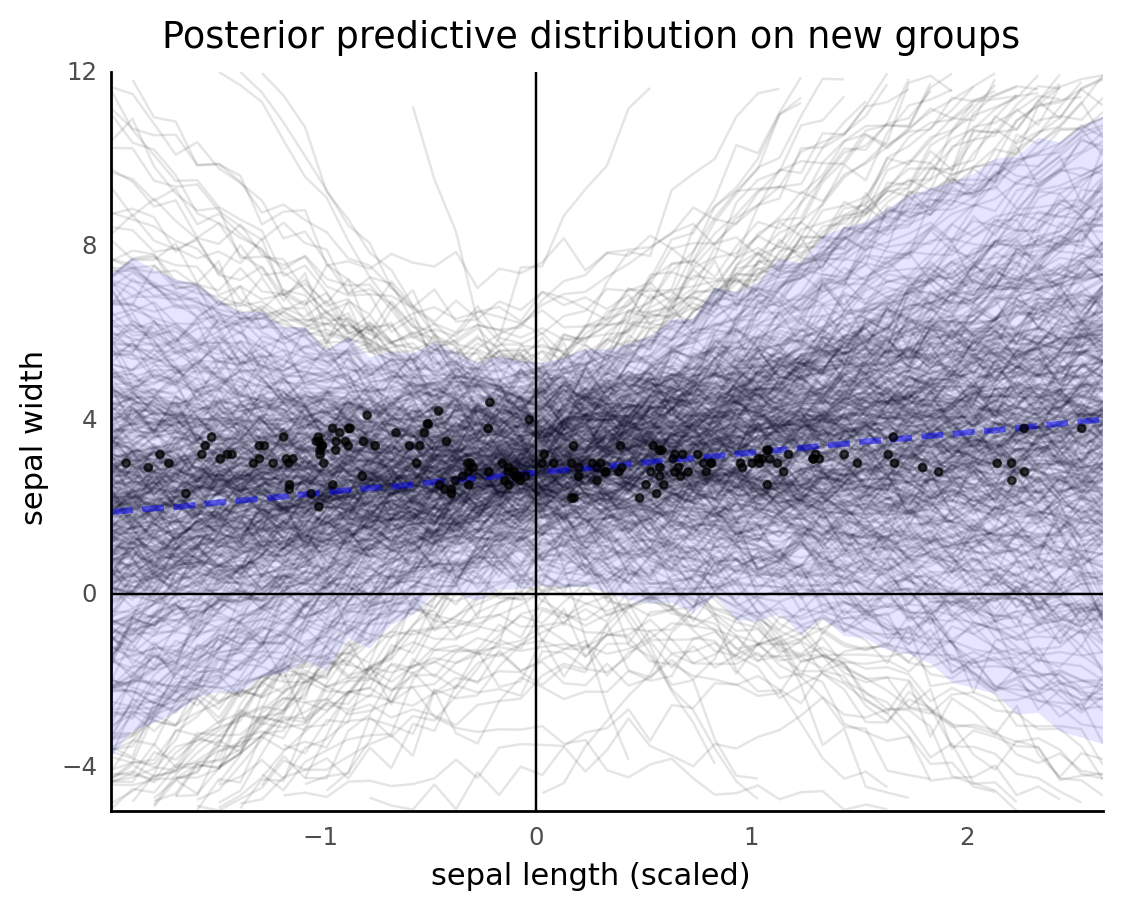

<ggplot: (352579988)>

In [25]:
_blue = "blue"

(
    gg.ggplot(
        new_ppc_df.query("draw < 500"),
        gg.aes(x="sepal_length_z", y="value"),
    )
    + gg.geom_line(gg.aes(group="draw"), alpha=0.1)
    + gg.geom_line(data=new_ppc_df_avg, color=_blue, size=1.2, linetype="--", alpha=0.5)
    + gg.geom_ribbon(
        gg.aes(ymin="hdi_low", ymax="hdi_high"),
        data=new_ppc_df_avg,
        fill=_blue,
        alpha=0.1,
    )
    + gg.geom_jitter(
        gg.aes(x="sepal_length_z", y="sepal_width"),
        data=iris,
        size=1,
        width=0.05,
        height=0,
        alpha=0.7,
    )
    + gg.geom_hline(yintercept=0)
    + gg.geom_vline(xintercept=0)
    + gg.scale_x_continuous(expand=(0, 0))
    + gg.scale_y_continuous(limits=(-5, 12), expand=(0, 0))
    + gg.labs(
        x="sepal length (scaled)",
        y="sepal width",
        title="Posterior predictive distribution on new groups",
    )
)

---

In [26]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Wed Nov 17 2021

Python implementation: CPython
Python version       : 3.9.7
IPython version      : 7.29.0

janitor   : 0.21.2
plotnine  : 0.8.0
pymc3     : 3.11.2
sys       : 3.9.7 | packaged by conda-forge | (default, Sep 29 2021, 20:33:18) 
[Clang 11.1.0 ]
seaborn   : 0.11.2
numpy     : 1.21.4
pandas    : 1.3.4
arviz     : 0.11.4
matplotlib: 3.4.3

Watermark: 2.2.0

